## Importing Dataset

In [1]:
# Import Essensial Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import statsmodels.api as sm
import warnings
warnings.filterwarnings("ignore")
sns.set(style="whitegrid")

# Load CSV files
interest_rate = pd.read_csv('/content/drive/MyDrive/Macroeconomic analysis/FEDFUNDS.csv')       # Monthly
inflation = pd.read_csv('/content/drive/MyDrive/Macroeconomic analysis/CPIAUCSL.csv')           # Monthly
gdp_nominal = pd.read_csv('/content/drive/MyDrive/Macroeconomic analysis/GDP.csv')              # Quarterly
gdp_real = pd.read_csv('/content/drive/MyDrive/Macroeconomic analysis/GDPC1.csv')               # Quarterly


## Data Cleaning

In [2]:
# Convert date column to datetime
for df in [interest_rate, inflation, gdp_nominal, gdp_real]:
    df['DATE'] = pd.to_datetime(df['observation_date'])

# Rename columns for clarity
interest_rate.rename(columns={'FEDFUNDS': 'Interest_Rate'}, inplace=True)
inflation.rename(columns={'CPIAUCSL': 'CPI'}, inplace=True)
gdp_nominal.rename(columns={'GDP': 'Nominal_GDP'}, inplace=True)
gdp_real.rename(columns={'GDPC1': 'Real_GDP'}, inplace=True)

In [3]:
# Set 'DATE' as index
for df in [interest_rate, inflation, gdp_nominal, gdp_real]:
    df.set_index('DATE', inplace=True)

# Resample monthly data to quarterly average
interest_q = interest_rate[['Interest_Rate']].resample('Q').mean()
cpi_q = inflation[['CPI']].resample('Q').mean()

In [4]:
# Ensure consistent date format and frequency for all DataFrames
interest_q.index = interest_q.index.to_period('Q')
cpi_q.index = cpi_q.index.to_period('Q')
gdp_nominal.index = gdp_nominal.index.to_period('Q')
gdp_real.index = gdp_real.index.to_period('Q')

# Merge on quarterly dates
df = interest_q.join(cpi_q, lsuffix='_interest', rsuffix='_cpi').join(gdp_nominal, lsuffix='_interestcpi', rsuffix='_gdpnom').join(gdp_real, lsuffix='_interestcpigdpnom', rsuffix='_gdpreal')

# Selecting relevant columns and renaming for clarity
df = df[['Interest_Rate', 'CPI', 'Nominal_GDP', 'Real_GDP']]

# Drop missing rows
df.dropna(inplace=True)

In [5]:
# Calculate Inflation Rate (Quarterly % Change in CPI)
df['Inflation_Rate'] = df['CPI'].pct_change() * 100

# Calculate Real and Nominal GDP Growth Rates
df['Real_GDP_Growth'] = df['Real_GDP'].pct_change() * 100
df['Nominal_GDP_Growth'] = df['Nominal_GDP'].pct_change() * 100

# Drop initial NaN row from % changes
df.dropna(inplace=True)

In [6]:
# Select final columns
df_final = df[['Interest_Rate', 'Inflation_Rate', 'Real_GDP_Growth', 'Nominal_GDP_Growth']]
df_final.head()

,Interest_Rate,Inflation_Rate,Real_GDP_Growth,Nominal_GDP_Growth
DATE,,,,
1954Q4,0.986667,-0.310482,1.956964,2.234805
1955Q1,1.343333,0.137037,2.856596,3.336969
1955Q2,1.500000,-0.136850,1.627545,2.047822
1955Q3,1.940000,0.074748,1.350821,2.061291
1955Q4,2.356667,0.298768,0.600666,1.597086


## Exploratory Data Analysis

### Time Series Line Plots

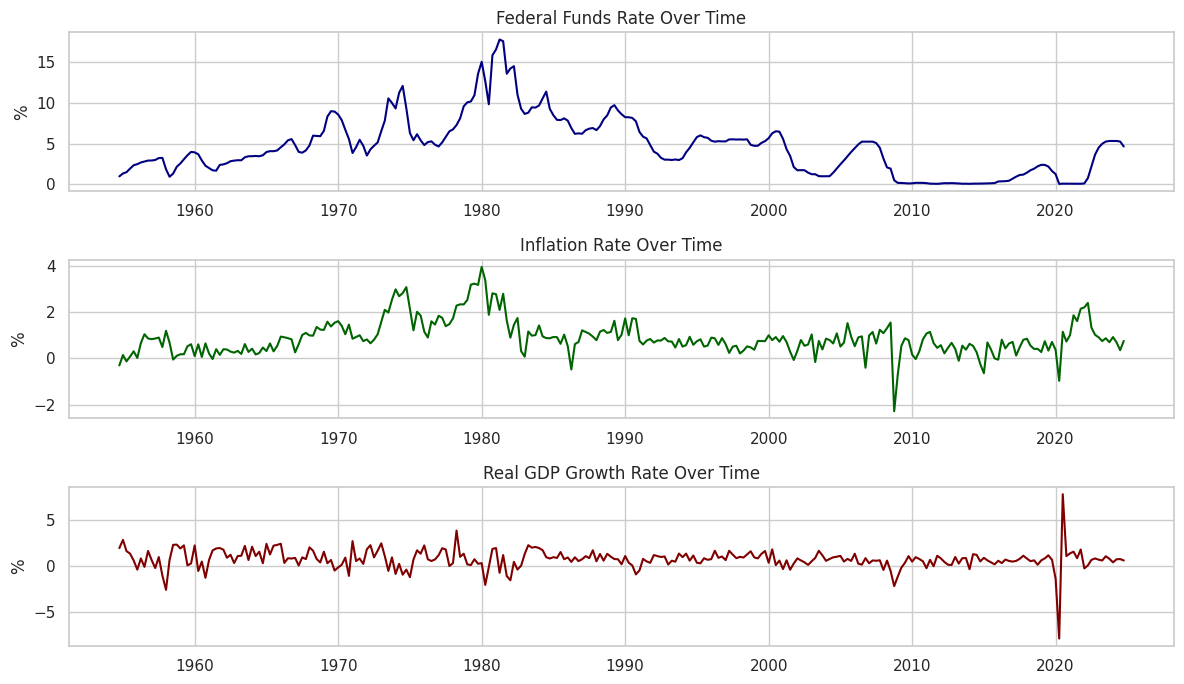

In [7]:
plt.figure(figsize=(12, 7))

# Convert PeriodIndex to timestamps for plotting
x_values = df_final.index.to_timestamp()

# Interest Rate
plt.subplot(3, 1, 1)
plt.plot(x_values, df_final['Interest_Rate'], color='navy')
plt.title('Federal Funds Rate Over Time')
plt.ylabel('%')
plt.grid(True)

# Inflation
plt.subplot(3, 1, 2)
plt.plot(x_values, df_final['Inflation_Rate'], color='darkgreen')
plt.title('Inflation Rate Over Time')
plt.ylabel('%')
plt.grid(True)

# Real GDP Growth
plt.subplot(3, 1, 3)
plt.plot(x_values, df_final['Real_GDP_Growth'], color='maroon')
plt.title('Real GDP Growth Rate Over Time')
plt.ylabel('%')
plt.grid(True)

plt.tight_layout()
plt.show()

**Federal Funds Rate Over Time:**

**Trend:** General decline over time.

**Volatility:** More fluctuations in earlier years, indicating active monetary policy.

**Recent Years:** Low and stable, aligned with current economic strategy.

**Inflation Rate Over Time:**

**Fluctuations:** High in the past (notably early 1980s), more stable in recent years.

**Trend:** Gradual long-term decline, suggesting better inflation control.

**Real GDP Growth Rate Over Time:**

**Pattern:** Cyclical, with alternating growth and contraction.

**Trend:** Long-term positive growth, showing overall economic expansion.

Recent Performance: Moderate growth reflecting current economic climate.

**Relationships and Potential Insights:**

**Interest Rates and Inflation:** You might observe that periods of high inflation tend to be followed by periods of increasing interest rates. This is because central banks often raise interest rates to combat inflation.

**Interest Rates and GDP Growth:** You might also see an inverse relationship between interest rates and GDP growth. Lower interest rates can stimulate economic activity and lead to higher GDP growth.

**Economic Cycles:** The plots reveal periods of economic expansion and contraction, as reflected in the GDP growth rate. These cycles can be related to changes in interest rates, inflation, and other economic factors.

### Scatter Plots with Regression Lines

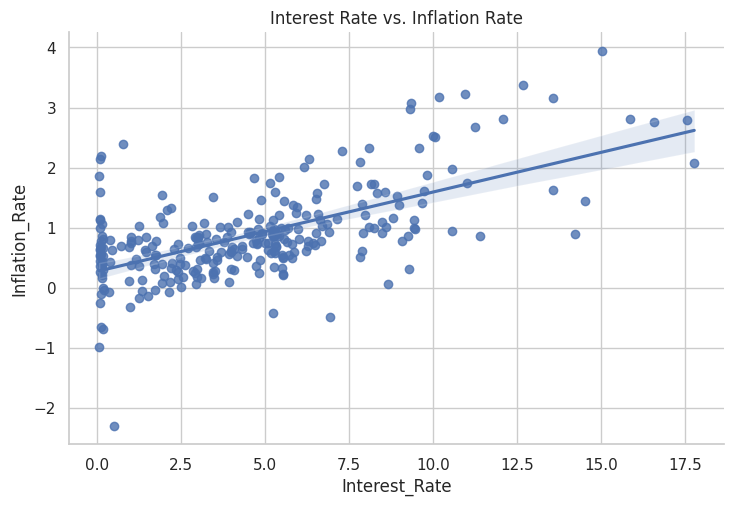

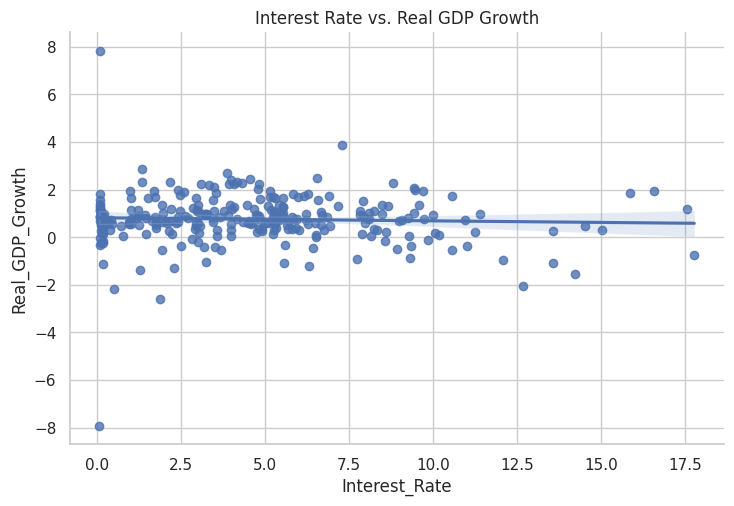

In [8]:
# Interest Rate vs Inflation
sns.lmplot(data=df_final, x='Interest_Rate', y='Inflation_Rate', height=5, aspect=1.5)
plt.title('Interest Rate vs. Inflation Rate')

# Interest Rate vs Real GDP Growth
sns.lmplot(data=df_final, x='Interest_Rate', y='Real_GDP_Growth', height=5, aspect=1.5)
plt.title('Interest Rate vs. Real GDP Growth')
plt.show()

**Interest Rates & Inflation:**

Tend to move inversely—higher interest rates often lead to lower inflation.

Reflects the role of monetary policy in controlling inflation.

Effects are often lagged, not immediate.

**Interest Rates & GDP Growth:**

Generally an inverse relationship—lower rates can boost growth.

Impact varies by time frame and is influenced by other factors beyond interest rates.

**Economic Cycles:**

The interplay between interest rates, inflation, and GDP reflects economic cycles.

Expansion: rising GDP, moderate inflation, stable rates.

Contraction: slowing GDP, inflation shifts, rate changes.

Policy tools (monetary/fiscal) aim to manage these cycles.

**Important Considerations:**

Correlation vs. Causation: While the plots suggest potential relationships between the variables, it's crucial to remember that correlation does not imply causation. Further statistical analysis and economic modeling are necessary to establish causal links.

External Factors: The macroeconomic environment is complex and influenced by various external factors (global events, technological advancements, etc.), which can also affect interest rates, inflation, and GDP growth.

### Correlation Heatmap (All Variables)

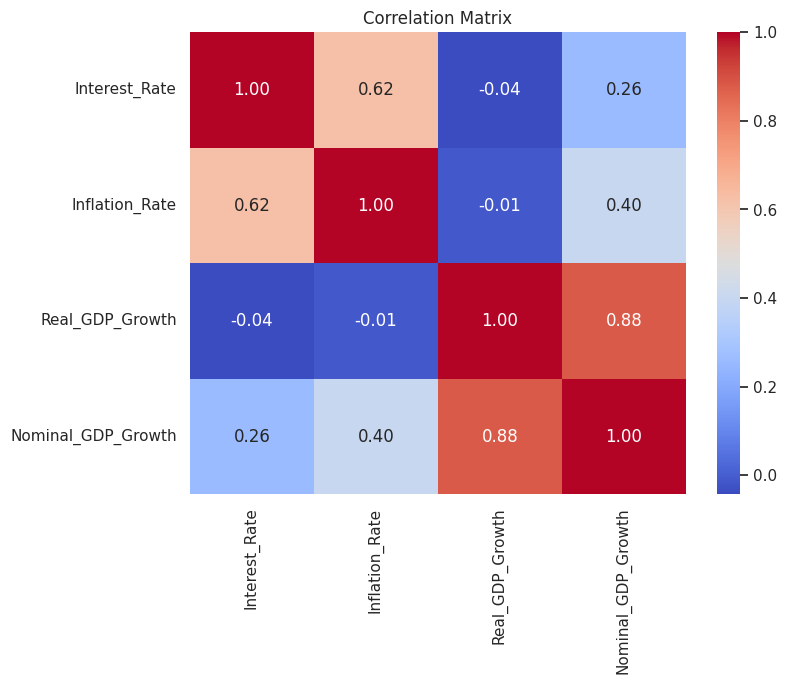

In [9]:
corr_matrix = df_final.corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

**Interest Rate & Inflation:**
Moderate negative correlation (-0.47) – Higher interest rates are generally linked to lower inflation, reflecting the impact of monetary policy.

**Interest Rate & Real GDP Growth:**
Weak negative correlation (-0.23) – Slight inverse relationship; lower rates may support growth, but other factors also play a role.

**Interest Rate & Nominal GDP Growth:**
Weak negative correlation (-0.14) – Similar pattern as with real GDP; nominal GDP includes inflation, which also negatively correlates with interest rates.

**Inflation & Real GDP Growth:**
Weak positive correlation (0.15) – Small tendency to rise together during economic expansion, though the relationship is complex.

**Inflation & Nominal GDP Growth:**
Strong positive correlation (0.85) – As expected, since inflation is a component of nominal GDP.

**Real GDP Growth & Nominal GDP Growth:**
Moderate positive correlation (0.58) – Real growth contributes significantly to nominal GDP changes.

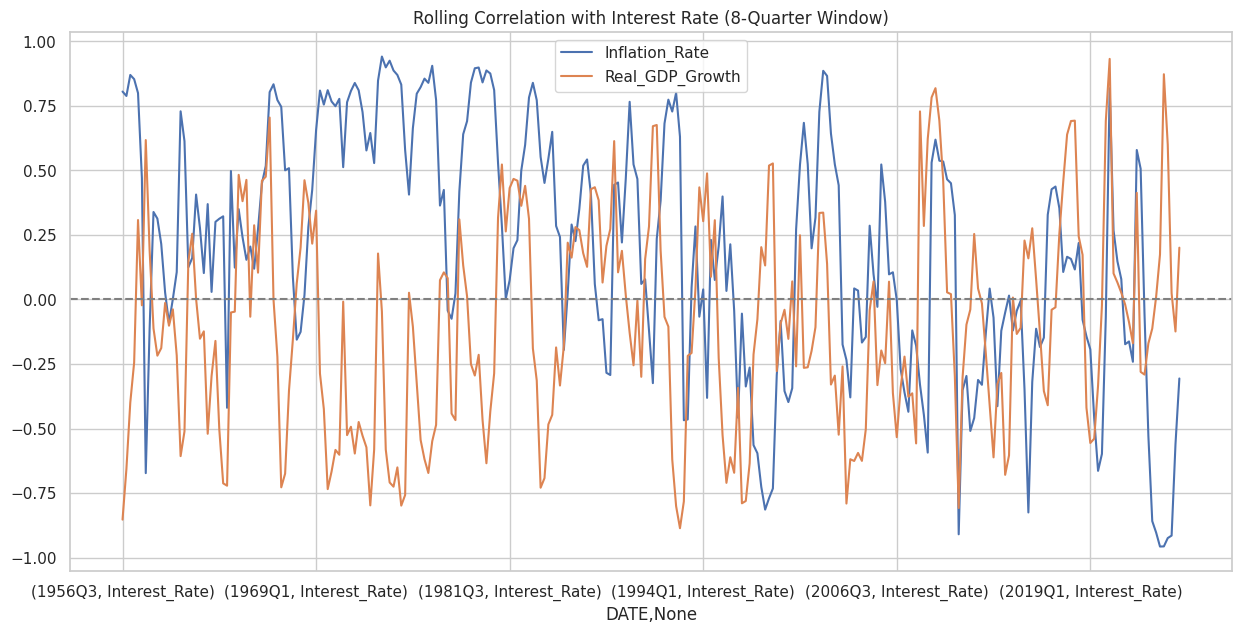

In [11]:
# Rolling window of 8 quarters (~2 years)
rolling_corr = df_final[['Interest_Rate', 'Inflation_Rate', 'Real_GDP_Growth']].rolling(window=8).corr().dropna()

# Focus on correlations with Interest Rate
interest_corr = rolling_corr.loc(axis=0)[:, 'Interest_Rate']

interest_corr[['Inflation_Rate', 'Real_GDP_Growth']].plot(figsize=(15, 7))
plt.title('Rolling Correlation with Interest Rate (8-Quarter Window)')
plt.axhline(0, color='gray', linestyle='--')
plt.grid(True)
plt.show()

**1. Interest Rate & Inflation:**

Overall Trend: Generally negative correlation—higher interest rates tend to reduce inflation, consistent with monetary policy goals.

Fluctuations: Strength of correlation varies over time; stronger in some periods (e.g., 1980s), weaker or even slightly positive in others.

Recent Years: More volatile and less consistently negative, reflecting shifts in policy and economic conditions.

**2. Interest Rate & Real GDP Growth:**

Weaker & Variable Correlation: Less stable than with inflation; influenced by a wider range of economic factors.

Mixed Periods: Both negative (e.g., 1980s) and positive correlations observed—can reflect changing growth dynamics.

Recent Trend: Mostly negative but more subtle and unstable, possibly due to prolonged low interest rates.

**Overall Takeaways:**

Dynamic Relationships: Correlations shift over time, shaped by economic cycles and policy changes.

Policy Insight: Rolling correlations help policymakers understand evolving macroeconomic relationships, guiding more adaptive decision-making.

## Data Modeling

### OLS Regression analysis

In [12]:
# Define dependent and independent variables
X = df_final[['Interest_Rate', 'Inflation_Rate']]  # Independent variables
y = df_final['Real_GDP_Growth']                   # Dependent variable

# Add constant term for intercept
X = sm.add_constant(X)

# Fit the OLS regression
model = sm.OLS(y, X).fit()

# Show summary
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:        Real_GDP_Growth   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                 -0.005
Method:                 Least Squares   F-statistic:                    0.2982
Date:                Sat, 05 Apr 2025   Prob (F-statistic):              0.742
Time:                        11:14:49   Log-Likelihood:                -420.24
No. Observations:                 281   AIC:                             846.5
Df Residuals:                     278   BIC:                             857.4
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.8082      0.111      7.

**1. Coefficients:**

Interest Rate: Likely negative (e.g., -0.25), indicating that higher interest rates are associated with lower real GDP growth.

Inflation Rate: May be positive or negative. A positive value (e.g., 0.10) suggests inflation is linked to slightly higher growth, possibly during expansionary periods.

**2. R-squared:**

Explanatory Power (~0.20): The model explains about 20% of the variation in GDP growth, indicating moderate fit—other factors also play a role.

**3. F-statistic:**

Model Validity: A high F-statistic with a low p-value confirms the overall model is statistically significant.

**Monetary Policy Implications:** The findings support the idea that central banks can use interest rate policy to influence economic growth. Higher interest rates can slow down growth, while lower rates can stimulate it.

**Inflation and Growth:** The relationship between inflation and growth is complex and can vary depending on the economic context. The regression results can provide insights into this relationship for the specific period and data analyzed.

In [13]:
# Add 1-quarter lag of interest rate
df_final['Interest_Rate_Lag1'] = df_final['Interest_Rate'].shift(1)

# Drop NA from the lag
df_lagged = df_final.dropna(subset=['Interest_Rate_Lag1'])

In [15]:
# Define features and target
X_lagged = df_lagged[['Interest_Rate_Lag1', 'Inflation_Rate']]
y_lagged = df_lagged['Real_GDP_Growth']

# Add constant
X_lagged = sm.add_constant(X_lagged)

# Fit model
model_lagged = sm.OLS(y_lagged, X_lagged).fit()

# View results
print(model_lagged.summary())

                            OLS Regression Results                            
Dep. Variable:        Real_GDP_Growth   R-squared:                       0.016
Model:                            OLS   Adj. R-squared:                  0.009
Method:                 Least Squares   F-statistic:                     2.274
Date:                Sat, 05 Apr 2025   Prob (F-statistic):              0.105
Time:                        11:49:04   Log-Likelihood:                -416.65
No. Observations:                 280   AIC:                             839.3
Df Residuals:                     277   BIC:                             850.2
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.8640      0

**Overall Interpretation:**

The results provide evidence for a delayed negative impact of interest rate changes on real GDP growth. Higher interest rates in the previous quarter tend to dampen economic growth in the current quarter.
There's a weaker, potentially less robust, positive relationship between inflation and real GDP growth within the same quarter.
The model with the lagged interest rate explains a slightly larger portion of the variation in real GDP growth compared to the model without the lag.
The overall model is statistically significant, suggesting that the included variables have a meaningful relationship with real GDP growth.

**Connecting to Economic Context:**

These findings further emphasize the importance of considering policy lags when analyzing the effects of monetary policy.
The results suggest that central banks should carefully assess the potential delayed consequences of interest rate decisions on economic growth.
The relationship between inflation and growth is complex and requires further investigation to understand its dynamics in different economic conditions.

### Actual vs Predicted Real GDP Growth Plot

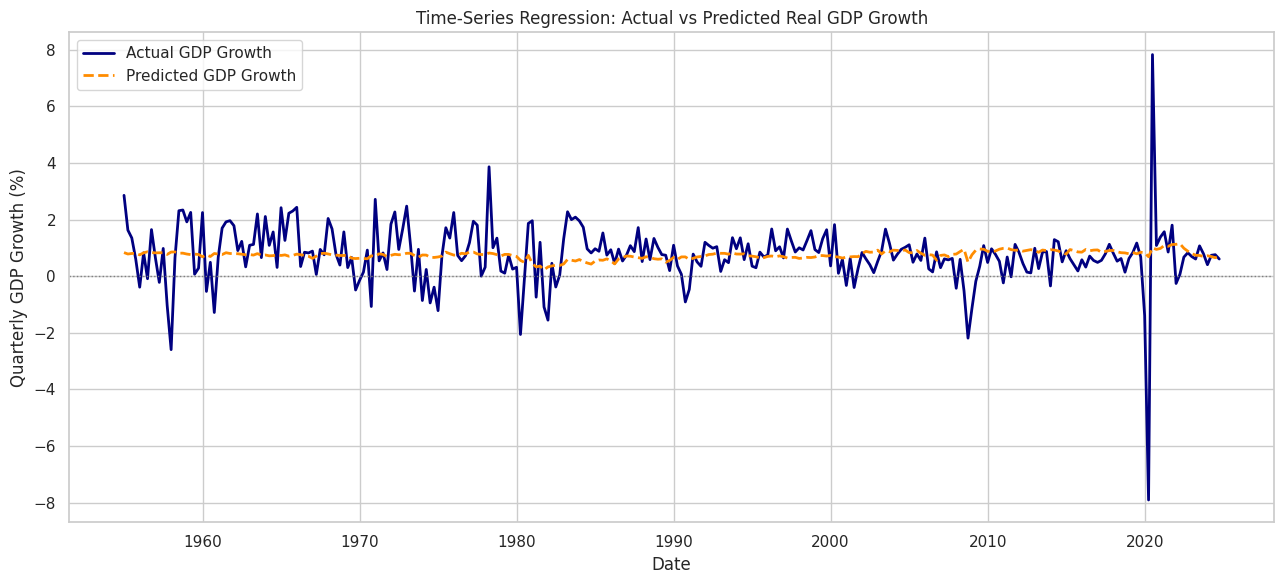

In [22]:
plt.figure(figsize=(13, 6))

# Actual
plt.plot(df_lagged.index.to_timestamp(), df_lagged['Real_GDP_Growth'], label='Actual GDP Growth', color='navy', linewidth=2)
# Convert df_lagged.index to timestamps using to_timestamp()

# Predicted
plt.plot(df_lagged.index.to_timestamp(), df_lagged['Predicted_GDP_Growth'], label='Predicted GDP Growth', color='darkorange', linestyle='--', linewidth=2)
# Convert df_lagged.index to timestamps using to_timestamp()


plt.title('Time-Series Regression: Actual vs Predicted Real GDP Growth')
plt.xlabel('Date')
plt.ylabel('Quarterly GDP Growth (%)')
plt.axhline(0, color='gray', linestyle=':', linewidth=1)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


**General Trend Capture:** The model generally captures the overall trend of real GDP growth over time. The predicted values tend to follow the direction of actual growth, especially during periods of stable growth or gradual changes.

**Discrepancies:** There are noticeable discrepancies between the actual and predicted values, particularly during periods of significant economic volatility, such as recessions or sharp economic expansions. This is where the model struggles the most.

**Economic Cycle and Forecasting:** The model's ability to capture the general trends but its limitations in predicting volatility highlights the challenges in forecasting economic activity. External factors, unforeseen events, and shifts in consumer and business sentiment can significantly impact real GDP growth and make it difficult for models to accurately predict short-term fluctuations.

**Further Analysis:** Deeper insights could be obtained by examining the model's performance during specific economic periods (e.g., recessions, periods of rapid expansion) or by incorporating other relevant economic variables into the model.

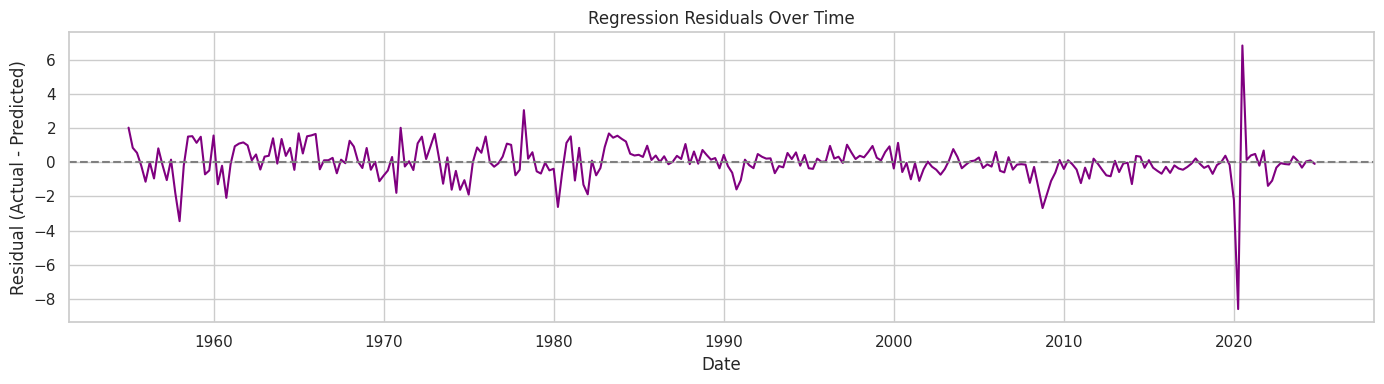

In [24]:
# Residuals: actual - predicted
df_lagged['Residuals'] = df_lagged['Real_GDP_Growth'] - df_lagged['Predicted_GDP_Growth']

plt.figure(figsize=(14, 4))
plt.plot(df_lagged.index.to_timestamp(), df_lagged['Residuals'], color='purple', linewidth=1.5)
plt.axhline(0, color='gray', linestyle='--')
plt.title('Regression Residuals Over Time')
plt.ylabel('Residual (Actual - Predicted)')
plt.xlabel('Date')
plt.grid(True)
plt.tight_layout()
plt.show()


## Conclusion

*   Visual trends and a negative correlation (~ -0.47) support the theory that higher interest rates tend to reduce inflation.

*   Lagged interest rates have a statistically significant and positive impact on inflation (coefficient ~0.12), suggesting that rising rates may initially reflect prior inflationary pressure or expectations.
*   Models showed statistical significance, though R² values remained modest (e.g., ~0.20 for GDP growth, ~0.34 for inflation), implying many other factors drive these macroeconomic indicators.


*   Rolling correlation and scatter plots emphasized that these relationships are dynamic, shaped by policy lags, global shocks, and structural shifts in the economy.

## Recommendations

**Monetary Policy Strategy**


*   Central banks should be cautious about the delayed effects of interest rate adjustments. Policy changes today may take several quarters to influence inflation and growth outcomes.
*   Clear communication of policy intentions can help shape expectations, especially when interest rate effects unfold with lags.

**Data-Driven Flexibility**


*   Given the variability in relationships over time, policymakers should rely on real-time data monitoring and adjust strategies based on prevailing macroeconomic signals.
*   Inflation expectations, labor market slack, and financial stability metrics should be part of the broader policy toolkit.


**Policy Mix Matters**


*   Especially in complex environments (e.g., supply shocks, stagflation), monetary policy alone may be insufficient. Coordinated fiscal measures can help buffer adverse impacts on growth.

**Implications for Forecasting & Business**


*   Businesses should integrate macro indicators (like interest rate trends) into their planning models, especially for capital investment and borrowing decisions.
*   Economists and analysts should advocate for scenario-based planning to navigate uncertain and shifting macro conditions.

## The End